# Meteorite Impacts

NASA has helpfully provided a dataset which lists recorded meteorite impacts - get it in `"Meteorite_Landings.csv"`. Can we utilise this dataset to predict the chance that, within 1000 years, a high-impact meteor will strike the planet?

Let's define high-impact as an asteroid greater than 1km in diameter. 

**Clean the data**

**Make the model distribution to fit the data, in this case we used lognorm, we but could be skewnorm**

**Work with the model that parametrized the data using .sf or .cdf**

**Test based on an specific threshold, in this case 1000KM asteroid converted to mass**

**find the probability of confirmation to Null Hypothesis and subtract that from 1**


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../data/Meteorite_Landings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass         45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45428 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


In [4]:
df.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


In [7]:
df2 = df.dropna(subset=['mass', 'year'])
df2 = df2[df2['mass'] > 0]

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45292 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45292 non-null  object 
 1   id           45292 non-null  int64  
 2   nametype     45292 non-null  object 
 3   recclass     45292 non-null  object 
 4   mass         45292 non-null  float64
 5   fall         45292 non-null  object 
 6   year         45292 non-null  float64
 7   reclat       38097 non-null  float64
 8   reclong      38097 non-null  float64
 9   GeoLocation  38097 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.8+ MB


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


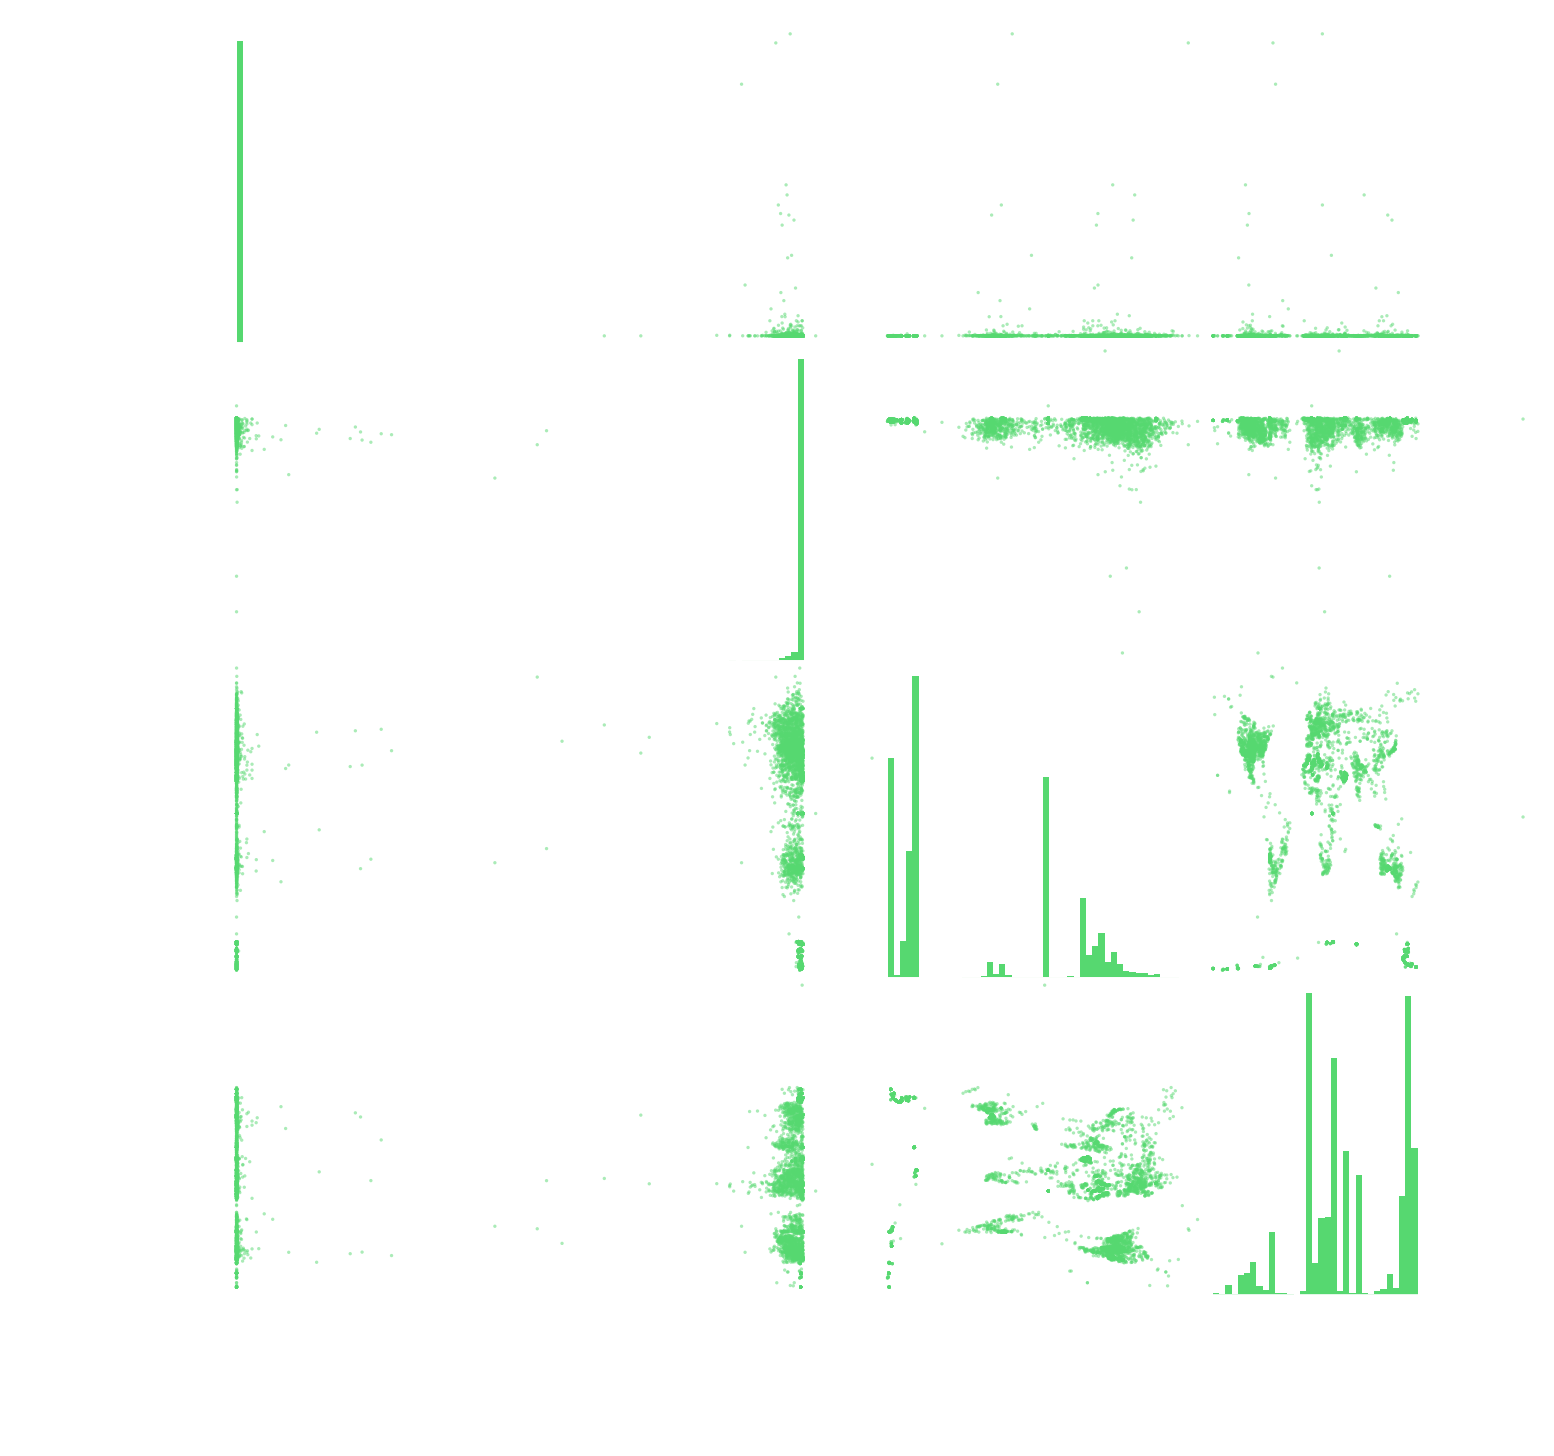

In [9]:
pd.plotting.scatter_matrix(df[['mass', 'year', 'reclat', 'reclong']], figsize=(7,7));

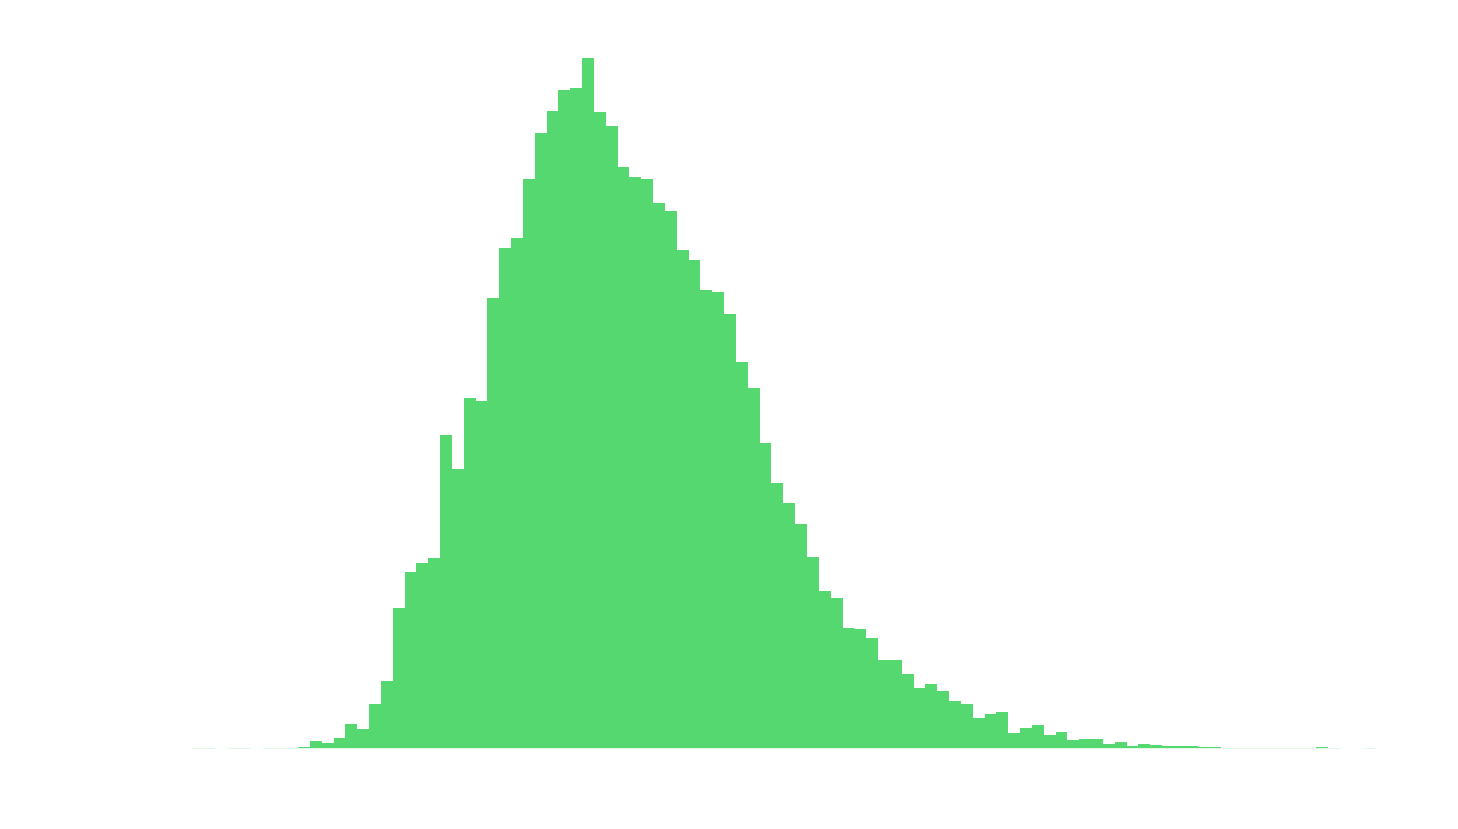

In [11]:
year = df2['year']
masses = df2['mass']
# log normal is good for showing distributions
logmass = np.log(masses)
plt.hist(logmass, bins=100);

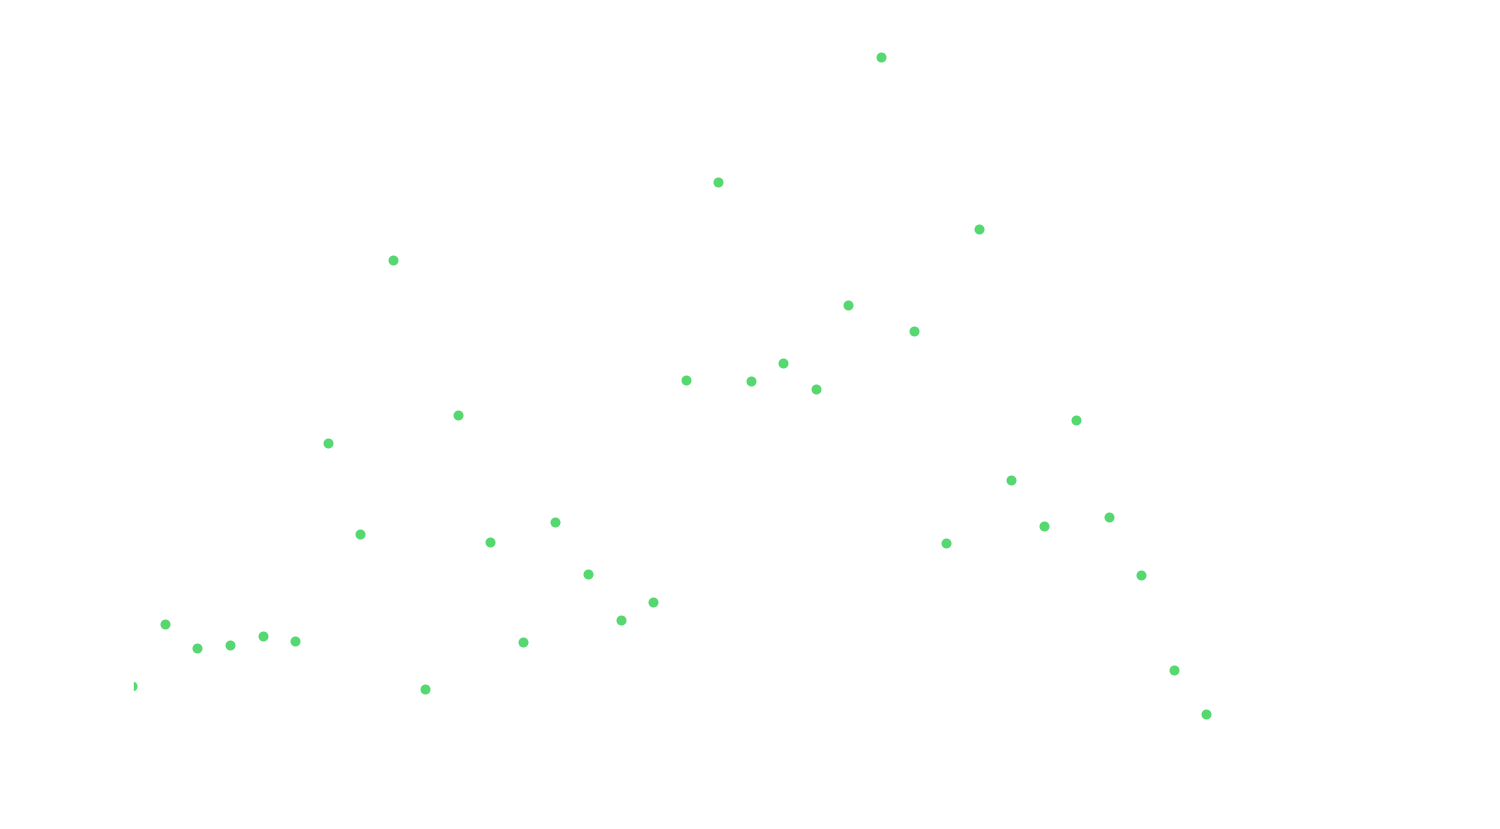

In [12]:
counts = year.value_counts()
plt.scatter(counts.index, counts)
plt.xlim(1980, 2020);

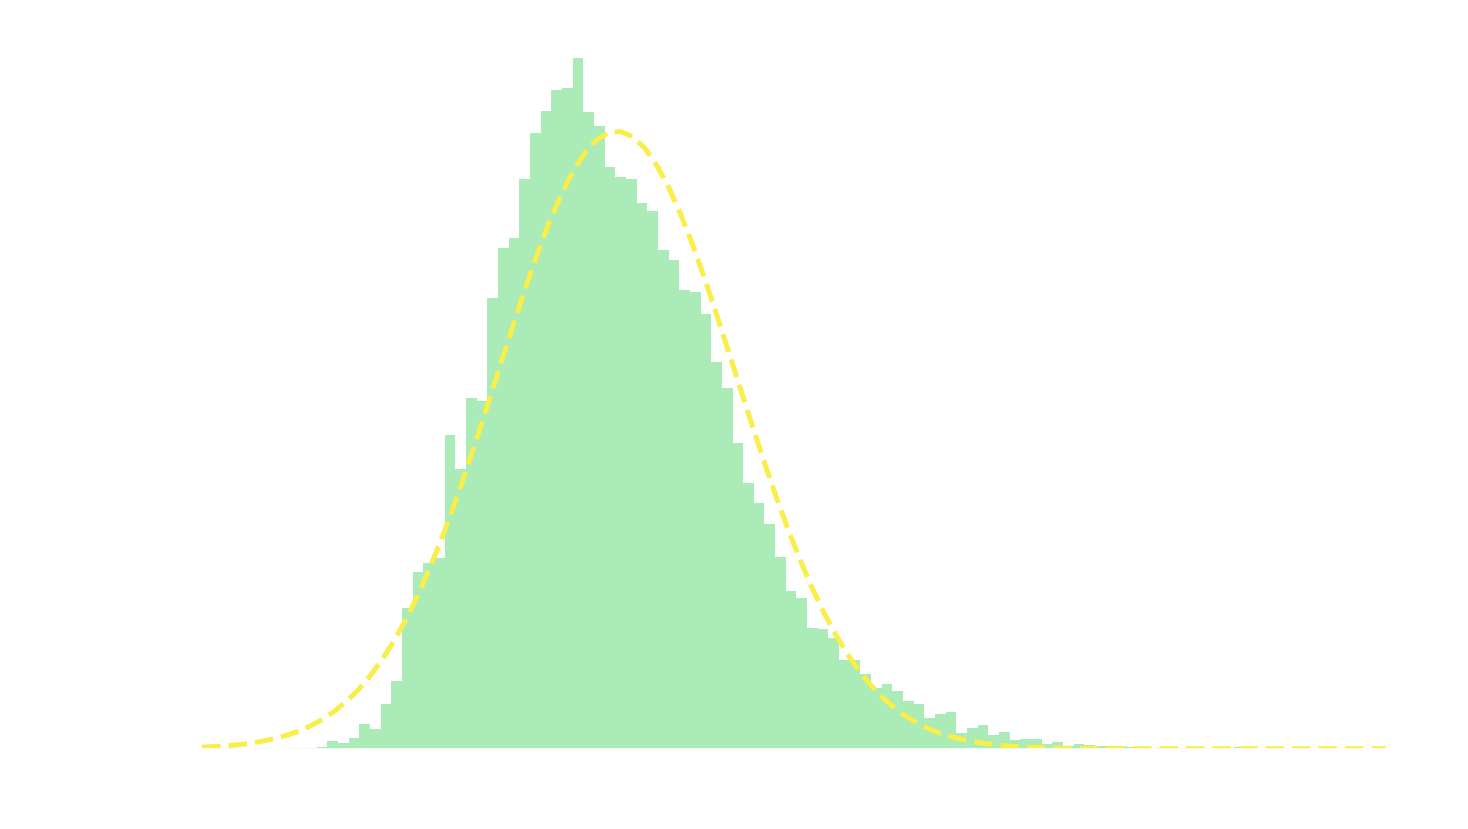

In [21]:
from scipy.stats import norm, skewnorm, lognorm
ms = np.linspace(-5, 20, 100)

mean, std = logmass.mean(), np.std(logmass)
pdf_norm = norm.pdf(ms, mean, std);
plt.hist(logmass, bins=100, density=True, alpha=0.5)
plt.plot(ms, pdf_norm);


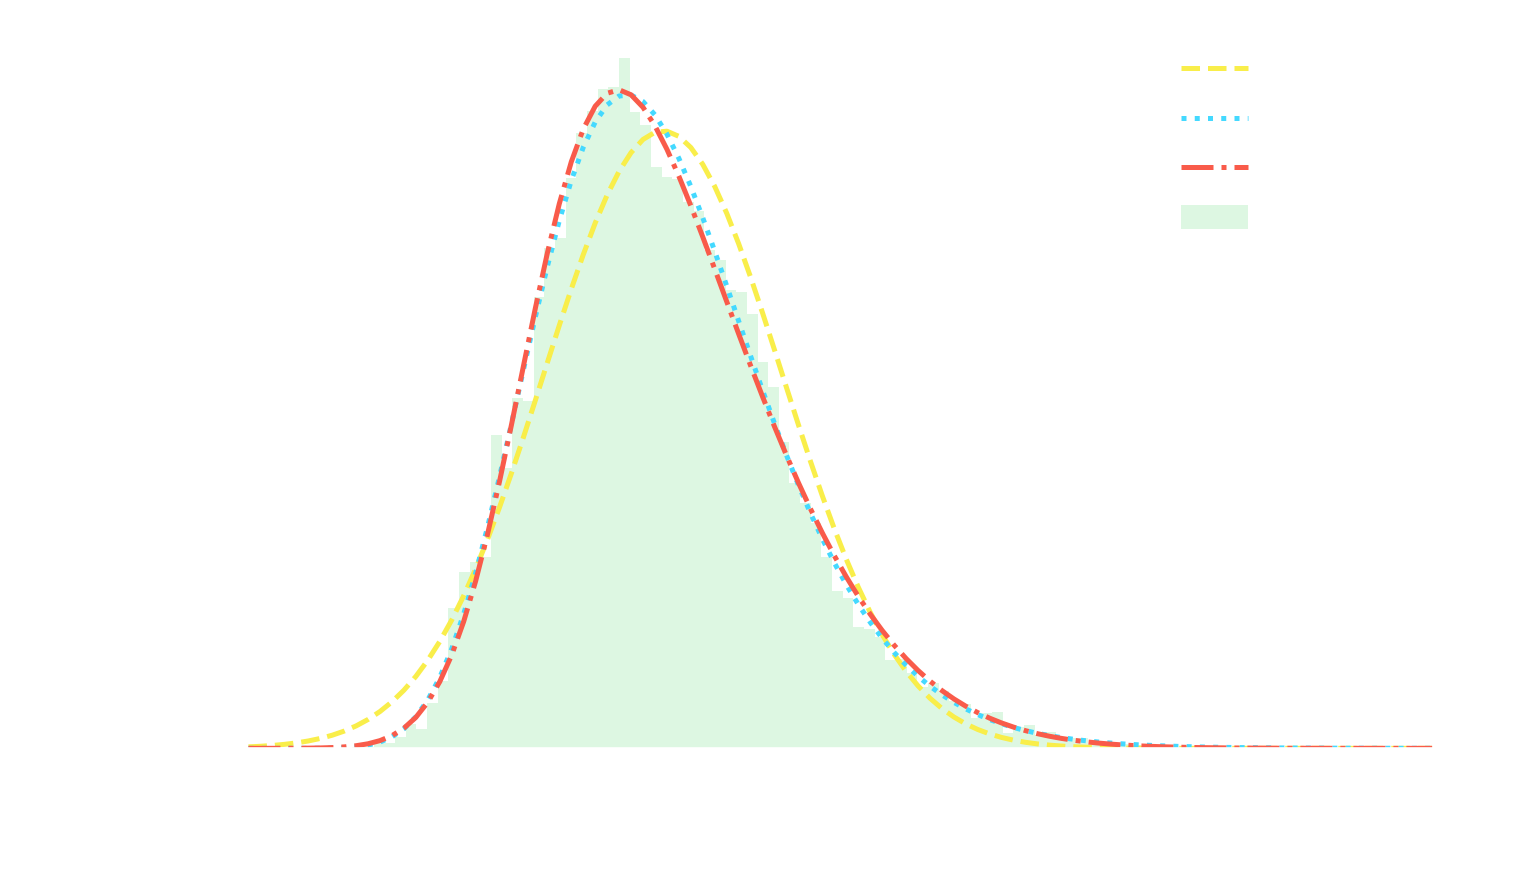

In [22]:
# Fitting the distribution into a modeling distribution;
p_lognorm = lognorm.fit(logmass)
pdf_lognorm = lognorm.pdf(ms, *p_lognorm)

p_skewnorm = skewnorm.fit(logmass)
pdf_skewnorm = skewnorm.pdf(ms, *p_skewnorm)

plt.hist(logmass, bins=100, density=True, alpha=0.2, label='Data')
plt.plot(ms, pdf_norm, label='Norm')
plt.plot(ms, pdf_lognorm, label="Log norm")
plt.plot(ms, pdf_skewnorm, label='Skew norm')
plt.legend()
plt.xlabel('Log Mass')
plt.ylabel('Probability');

In [23]:
# changing the 1km size that is our threshold to mass
mass_of_doom = np.log((4/3) * np.pi * 500**3 * 1600 * 1000) # spherical approximation
mass_of_doom

34.36175044077777

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


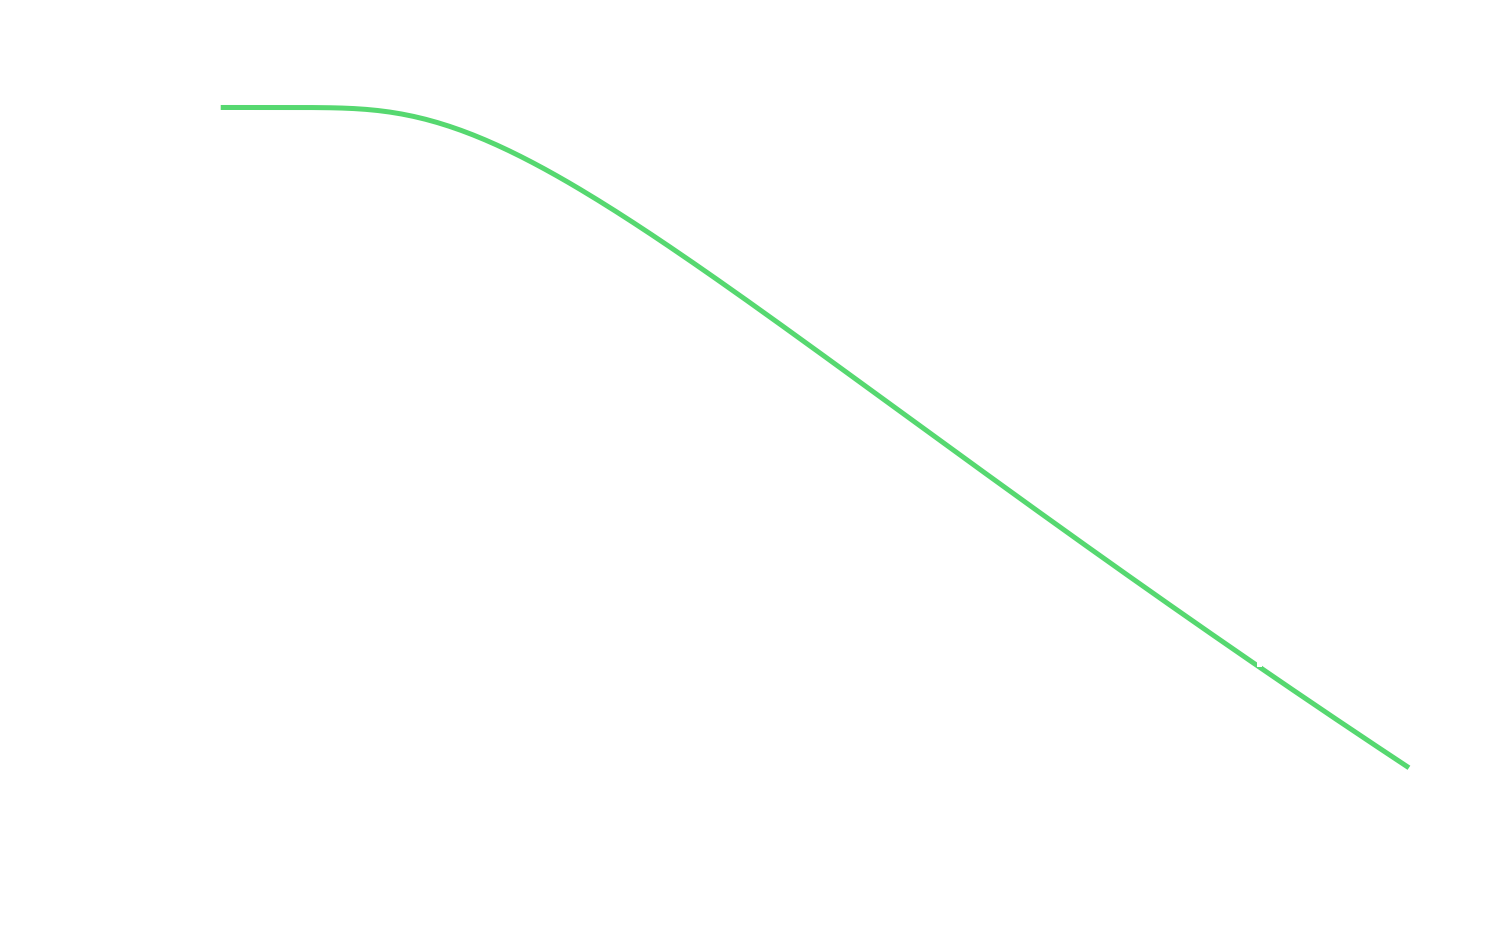

In [25]:
# Based on our parametized data *p_lognorm => p_lognorm = lognorm.fit(logmass) we are grabbing a survival
# function from that

ms2 = np.linspace(-5, 40, 200)
plt.plot(ms2, lognorm.logsf(ms2, *p_lognorm))
plt.axvline(mass_of_doom, ls='--')
plt.xlabel('log mass')
plt.ylabel('log probability')
plt.title('Log probability of asteroid being over given mass');


So we have here the probability of an asteroid being above a certain mass when it hits Earth. But to answer the question "What is the probability that one or more asteroids of high mass strike Earth in 1000 years?" we need to factor in the actual time component. Assume that in the next 1000 years, we predict to have $N$ impacts.

$$P(>=1\  {\rm highmass}) = 1 - P(0\ {\rm highmass}) = 1 - P(N\ {\rm not\_highmass}) = 1 - P({\rm not\_highmass})^N$$

Imagine a similar question: Prob of getting no sixes in 5 rolls. Well its $$\frac{5}{6}\times\frac{5}{6}\times\frac{5}{6}\times\frac{5}{6}\times\frac{5}{6} = \left(\frac{5}{6}\right)^5 $$
The prob of getting one or more sixes is then $1 - (5/6)^5$.

So to give a number, we need to calculate $N$ from the yearly rate, number of years, and our detection efficiency and use that with the probability that any given impact is not high mass.

### 1 tail-test

In [31]:
prob_small_mass = lognorm.logcdf(mass_of_doom, *p_lognorm)
# print(np.exp(prob_small_mass))
frac_sky_monitered = 0.2
num_years = 1000
num_events = num_years * counts.max() / frac_sky_monitered
prob_bad = 1 - np.exp(num_events * prob_small_mass)
print(f"Prob a >1km asteroid impacts with {num_years} years is {prob_bad * 100:.2f}%")


Prob a >1km asteroid impacts with 1000 years is 0.67%
